## Setup

In [ ]:
import os
import pandas as pd
import torch
from torch.utils import data
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
pip install gitpython # to download datasets for git repository

     |████████████████████████████████| 180 kB 4.1 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 


In [ ]:
from git import Repo

Repo.clone_from("https://github.com/iwls2020-lsml-contest/iwls2020-lsml-contest.git", "iwls2020-lsml-contest")

<git.repo.base.Repo '/content/iwls2020-lsml-contest/.git'>

### Visualizing Data

In [ ]:
# read file from train directory
file_data = open('iwls2020-lsml-contest/benchmarks/train/ex10.train.pla', 'r')
file_data = file_data.readlines()

# preprocess file to separate inputs and outputs
x = []
y = []
for line in file_data:
  if not (line.startswith('.')):
    x.append( line[:line.index(' ')] )
    y.append( line[ line.index(' ')+1:line.index(' ')+2 ] ) 

num_samples_per_file = len(x)
num_bits_in_sample = len(x[0])

# print details
print("num_samples_per_file = ", num_samples_per_file)
print("num_bits_in_sample = ", num_bits_in_sample)

# print 5 samples

print("\n5 training samples with labels: ")
print( '    x','                             y')
for i in range(5):
  print(x[i], ' ', y[i])


num_samples_per_file =  6400
num_bits_in_sample =  32

5 training samples with labels: 
    x                              y
00100001111011111011001101001010   0
10011010011000101011111010010001   0
00101010100111101000011001000111   0
11010110101001111000100000100011   1
00001010001111100001011001111000   0


## Training one circuit (one file with 6400 samples)

In [ ]:
''' convert data to tensors  '''

# separates string to characters 
def split(word): 
    return [char for char in word] 

for i,input in enumerate(x):
  x[i] = split(input)
  # convert each character to integer
  for j,bit in enumerate(x[i]):
      x[i][j] = int(bit)

features = torch.FloatTensor(x)
y = [int(i) for i in y]
labels = torch.FloatTensor(y)

In [ ]:
''' Form a data iterator with batch size 10 '''

def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [ ]:
''' Setting the neural network '''

class BinaryClassification(nn.Module):
  def __init__(self, input_size=32):
    super(BinaryClassification, self).__init__()
    self.linear1 = nn.Linear(input_size,10)
    self.linear2 = nn.Linear(10,1)

  def forward(self, x):
    x = torch.sigmoid( self.linear1(x) )
    x = torch.sigmoid( self.linear2(x) )
    return x

# instantating the network, loss function and optimizer

net = BinaryClassification(32) # set input size as size of sample

Loss = nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

In [ ]:
# print model
print(net)

BinaryClassification(
  (linear1): Linear(in_features=32, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=1, bias=True)
)


In [ ]:
# define accuracy function

def accuracy(output,labels):
  output = output >=0.5
  acc = torch.sum(output==labels)/len(labels)
  return acc

In [ ]:
''' train the model '''

num_epochs = 250
acc_list = []
loss_list = []
for epoch in range(num_epochs):
    for X, y in data_iter:
        output = net(X)
        l = Loss(output, y.reshape(-1,1) )
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    if (epoch%10==0):
      acc = accuracy(net(features), labels.reshape(-1,1))
      l = Loss(net(features), labels.reshape(-1,1))
      acc_list.append(acc)
      loss_list.append(l)
      print(f'epoch {epoch + 1:3d}, loss {l:.3f}, acc {acc:.3f}')

epoch   1, loss 0.638, acc 0.659
epoch  11, loss 0.557, acc 0.672
epoch  21, loss 0.493, acc 0.705
epoch  31, loss 0.479, acc 0.711
epoch  41, loss 0.467, acc 0.732
epoch  51, loss 0.456, acc 0.727
epoch  61, loss 0.445, acc 0.736
epoch  71, loss 0.433, acc 0.744
epoch  81, loss 0.422, acc 0.747
epoch  91, loss 0.410, acc 0.752
epoch 101, loss 0.399, acc 0.761
epoch 111, loss 0.387, acc 0.769
epoch 121, loss 0.375, acc 0.770
epoch 131, loss 0.363, acc 0.788
epoch 141, loss 0.350, acc 0.796
epoch 151, loss 0.337, acc 0.803
epoch 161, loss 0.326, acc 0.814
epoch 171, loss 0.317, acc 0.822
epoch 181, loss 0.309, acc 0.828
epoch 191, loss 0.303, acc 0.833
epoch 201, loss 0.298, acc 0.836
epoch 211, loss 0.294, acc 0.839
epoch 221, loss 0.289, acc 0.836
epoch 231, loss 0.286, acc 0.840
epoch 241, loss 0.283, acc 0.842


Text(0, 0.5, 'loss')

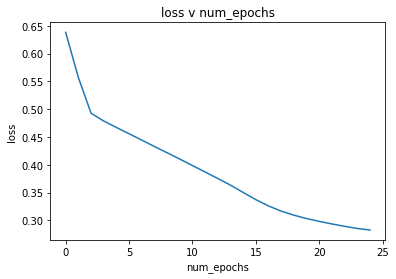

In [ ]:
plt.plot(loss_list)
plt.title ('loss v num_epochs')
plt.xlabel('num_epochs')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

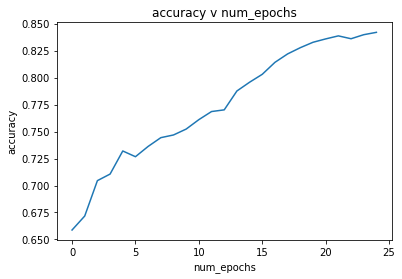

In [ ]:
plt.plot(acc_list)
plt.title ('accuracy v num_epochs')
plt.xlabel('num_epochs')
plt.ylabel('accuracy')

# Running over all 100 circuits

### For each circuit/ truth table:

* read the .pla file (circuit)
* preprocess the .pla file to get the features and labels as tensors
* form a dataloader
* define the neural net
* train the model for 100 epochs
* test the model, note the accuracy


In [ ]:
# get all the train and test files

train_files = []
test_files = []

for (dirpath, dirnames, filenames) in os.walk( 'iwls2020-lsml-contest/benchmarks/train/' ):
    for file in filenames:
      train_files.append(os.path.join(dirpath,file) )
for (dirpath, dirnames, filenames) in os.walk( 'iwls2020-lsml-contest/benchmarks/test/' ):
    for file in filenames:
      test_files.append(os.path.join(dirpath,file) )

train_files.sort()
test_files.sort()

## Experiment 1: 2 layer NN

In [ ]:
# Experiment 1 - 2 layer NN

def split(word): 
    return [char for char in word] 

def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

class BinaryClassification(nn.Module):
  def __init__(self, input_size=32):
    super(BinaryClassification, self).__init__()
    self.linear1 = nn.Linear(input_size,10)
    self.linear2 = nn.Linear(10,1)

  def forward(self, x):
    x = torch.sigmoid( self.linear1(x) )
    x = torch.sigmoid( self.linear2(x) )
    return x

def accuracy(output,labels):
  output = output >=0.5
  acc = torch.sum(output==labels)/len(labels)
  return acc

def get_tensors_from_example_files(train_file, test_file):
  ''' get features and label tensors from training and test files'''
  file_train_data = open(train_file, 'r')
  file_train_data = file_train_data.readlines()

  file_test_data = open(test_file, 'r')
  file_test_data = file_test_data.readlines()

  # preprocess files to separate inputs and outputs
  x_train = []
  y_train = []
  for line in file_train_data:
    if not (line.startswith('.')):
      x_train.append( line[:line.index(' ')] )
      y_train.append( line[ line.index(' ')+1:line.index(' ')+2 ] ) 

  x_test = []
  y_test = []
  for line in file_test_data:
    if not (line.startswith('.')):
      x_test.append( line[:line.index(' ')] )
      y_test.append( line[ line.index(' ')+1:line.index(' ')+2 ] ) 

  # convert data to tensors
  for i,input in enumerate(x_train):
    x_train[i] = split(input)
    # convert each character to integer
    for j,bit in enumerate(x_train[i]):
        x_train[i][j] = int(bit)
  features_train = torch.FloatTensor(x_train)
  y_train = [int(i) for i in y_train]
  labels_train = torch.FloatTensor(y_train)

  for i,input in enumerate(x_test):
    x_test[i] = split(input)
    # convert each character to integer
    for j,bit in enumerate(x_test[i]):
        x_test[i][j] = int(bit)
  features_test = torch.FloatTensor(x_test)
  y_test = [int(i) for i in y_test]
  labels_test = torch.FloatTensor(y_test)

  return features_train, labels_train, features_test, labels_test

def get_dataloaders(features_train, labels_train, features_test, labels_test):
  ''' form iterable dataloaders for features and labels'''
  batch_size = 10
  train_data_iter = load_array((features_train, labels_train), batch_size)
  test_data_iter = load_array((features_train, labels_train), batch_size)
  return train_data_iter, test_data_iter

def define_neural_net(input_size):

  net = BinaryClassification(input_size)
  net.to(device)
  Loss = nn.BCELoss()
  optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

  return net, Loss, optimizer

def train_truth_table( net, Loss, optimizer, train_data_iter, num_epochs, features_train, labels_train ):

  net.train()
  for epoch in range(num_epochs):
      for X, y in train_data_iter:
          X = X.cuda()
          y = y.cuda()
          output = net(X)
          l = Loss(output, y.reshape(-1,1) )
          optimizer.zero_grad()
          l.backward()
          optimizer.step()
      if (epoch%10==0):
        acc = accuracy(net(features_train.cuda()).cpu(), labels_train.reshape(-1,1))
        l = Loss(net(features_train.cuda()).cpu(), labels_train.reshape(-1,1))
  
  return net

def test_net( net, test_data_iter):
  acc = 0
  net.eval()
  with torch.no_grad():
    for X,y in test_data_iter:
      X = X.cuda()
      output = net(X)
      acc = acc + accuracy(output.cpu(), y.reshape(-1,1))
    acc = acc/ len(test_data_iter)
  return acc


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Run experiment 1

# read the .pla file
# preprocess the .pla file to get the features and labels as tensors
# form a dataloader
# define the neural net
# train the model for 100 epochs
# test the model, note the accuracy

results = []
for i in range(len(train_files)):
  
  # get id of circuit
  ex_id = train_files[i][ train_files[i].index('ex'):train_files[i].index('ex')+4  ]
  
  # read the .pla file and preprocess the .pla file to get the features and labels as tensors
  features_train, labels_train, features_test, labels_test = get_tensors_from_example_files( train_files[i], test_files[i] )
  
  # form dataloaders
  train_data_iter, test_data_iter = get_dataloaders( features_train, labels_train, features_test, labels_test )
  
  # get input size
  input_size = features_train[0].size()[0]
  
  # form net
  net, Loss, optimizer = define_neural_net( input_size )

  # train
  net = train_truth_table( net, Loss, optimizer, train_data_iter, 100, features_train, labels_train )
  
  #get accuracy
  test_accuracy = test_net( net, test_data_iter )

  # print info
  if (i%5==0):
    print("\nworking on truth table: ", ex_id)
    print("input size = ", input_size)
    print("test accuracy achieved: ", test_accuracy.item())

  # get result and append results list
  result = (ex_id, input_size, test_accuracy.item() )
  results.append( result )

working on truth table:  ex00
input size =  32
test accuracy achieved:  0.9860938787460327
working on truth table:  ex05
input size =  128
test accuracy achieved:  0.9757814407348633
working on truth table:  ex10
input size =  32
test accuracy achieved:  0.8924988508224487
working on truth table:  ex15
input size =  32
test accuracy achieved:  0.9226554036140442
working on truth table:  ex20
input size =  16
test accuracy achieved:  0.5539065003395081
working on truth table:  ex25
input size =  64
test accuracy achieved:  1.0
working on truth table:  ex30
input size =  20
test accuracy achieved:  0.9978125691413879
working on truth table:  ex35
input size =  120
test accuracy achieved:  0.9942188262939453
working on truth table:  ex40
input size =  16
test accuracy achieved:  0.6615628004074097
working on truth table:  ex45
input size =  34
test accuracy achieved:  0.5843757390975952
working on truth table:  ex50
input size =  19
test accuracy achieved:  0.9592183232307434
working on t

In [ ]:
results_list = results

In [ ]:
results = np.asarray([res[2] for res in results_list])

In [ ]:
# average accuracy over all benchmarks
avg_accuracy = np.sum(results)/len(results)
print("overall accuracy across 100 benchmarks= ", avg_accuracy*100, " %")

overall accuracy across 100 benchmarks=  91.77999836206436  %


Text(0, 0.5, 'Avg. accuracy for benchmark category')

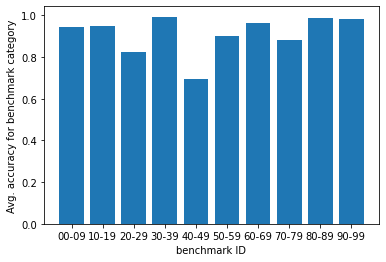

In [ ]:
# average accuracy by category (10 benchmarks per category)
avg_accuracy_per_category = np.zeros((10))
for i in range(10):
  avg_accuracy_per_category[i] = np.average(results[i*10:i*10+9])

# print(avg_accuracy_per_category)

x_labels = np.array(['00-09','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90-99'])
plt.bar(x_labels,avg_accuracy_per_category)
plt.xlabel('benchmark ID')
plt.ylabel('Avg. accuracy for benchmark category')

In [ ]:
# analysis of input_size v accuracy
# input_size_acc = [[input_size,num_occurences, sum_accuracies],[],...]

# get input sizes
input_sizes = []
for i,entry in enumerate(results_list):
  if entry[1] not in input_sizes:
    input_sizes.append(entry[1])

input_sizes = np.asarray(input_sizes).astype(np.float)
input_sizes = np.sort(input_sizes)
# print(input_sizes)
# print(np.shape(input_sizes))

input_size_acc = np.zeros((len(input_sizes),3))
input_size_acc[:,0] = input_sizes
# print(input_size_acc)

for i,entry in enumerate(results_list):
  idx = np.where(input_size_acc[:,0] == entry[1])
  input_size_acc[idx,1] = input_size_acc[idx,1]+1
  input_size_acc[idx,2] = input_size_acc[idx,2]+entry[2]

Text(0, 0.5, 'average_accuracy')

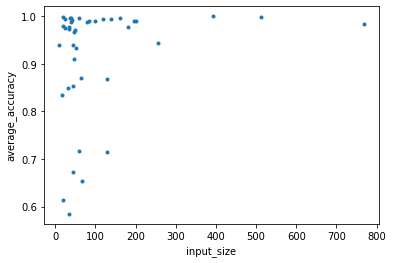

In [ ]:
plt.plot( input_size_acc[:,0], input_size_acc[:,2]/ input_size_acc[:,1], '.' )
plt.xlabel('input_size')
plt.ylabel('average_accuracy')

## Experiment 2: 3 layer NN

In [ ]:
# 3 layer NN

class BinaryClassification(nn.Module):
  def __init__(self, input_size=32):
    super(BinaryClassification, self).__init__()
    self.linear1 = nn.Linear(input_size, input_size//2)
    self.linear2 = nn.Linear(input_size//2, input_size//4)
    self.linear3 = nn.Linear(input_size//4,1)

  def forward(self, x):
    x = torch.sigmoid( self.linear1(x) )
    x = torch.sigmoid( self.linear2(x) )
    x = torch.sigmoid( self.linear3(x) )
    return x

In [ ]:
# Run experiment 2

# read the .pla file
# preprocess the .pla file to get the features and labels as tensors
# form a dataloader
# define the neural net
# train the model for 100 epochs
# test the model, note the accuracy

results = []
for i in range(len(train_files)):
  
  # get id of circuit
  ex_id = train_files[i][ train_files[i].index('ex'):train_files[i].index('ex')+4  ]
  
  # read the .pla file and preprocess the .pla file to get the features and labels as tensors
  features_train, labels_train, features_test, labels_test = get_tensors_from_example_files( train_files[i], test_files[i] )
  
  # form dataloaders
  train_data_iter, test_data_iter = get_dataloaders( features_train, labels_train, features_test, labels_test )
  
  # get input size
  input_size = features_train[0].size()[0]
  
  # form net
  net, Loss, optimizer = define_neural_net( input_size )

  # train
  net = train_truth_table( net, Loss, optimizer, train_data_iter, 100, features_train, labels_train )
  
  #get accuracy
  test_accuracy = test_net( net, test_data_iter )

  # print info
  if (i%5==0):
    print("\nworking on truth table: ", ex_id)
    # print("input size = ", input_size)
    print("test accuracy achieved: ", test_accuracy.item())

  # get result and append results list
  result = (ex_id, input_size, test_accuracy.item() )
  results.append( result )


working on truth table:  ex00
test accuracy achieved:  0.5079686641693115

working on truth table:  ex05
test accuracy achieved:  0.9831253886222839

working on truth table:  ex10
test accuracy achieved:  0.7435933351516724

working on truth table:  ex15
test accuracy achieved:  0.8329672813415527

working on truth table:  ex20
test accuracy achieved:  0.5031250715255737

working on truth table:  ex25
test accuracy achieved:  0.4989064335823059

working on truth table:  ex30
test accuracy achieved:  0.9975000619888306

working on truth table:  ex35
test accuracy achieved:  0.994062602519989

working on truth table:  ex40
test accuracy achieved:  0.5021877288818359

working on truth table:  ex45
test accuracy achieved:  0.5206252336502075

working on truth table:  ex50
test accuracy achieved:  0.7217190265655518

working on truth table:  ex55
test accuracy achieved:  0.9345308542251587

working on truth table:  ex60
test accuracy achieved:  0.8509357571601868

working on truth table:  